# SmoothGrad and Rise algorithms

## Loading the Data and Preprocessing

In [1]:
# Notebook based on https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html#Vanilla-Saliency

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
model = VGG16()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
Predicted label: library (76.03%)
top 5:
[[('n03661043', 'library', np.float32(0.7603098)), ('n02788148', 'bannister', np.float32(0.051680896)), ('n04204347', 'shopping_cart', np.float32(0.034831587)), ('n02871525', 'bookshop', np.float32(0.034148276)), ('n04311004', 'steel_arch_bridge', np.float32(0.032014757))]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Predicted label: harp (13.32%)
top 5:
[[('n03495258', 'harp', np.float32(0.13321577)), ('n04258138', 'solar_dish', np.float32(0.090279914)), ('n04296562', 'stage', np.float32(0.08122053)), ('n03452741', 'grand_piano', np.float32(0.040272143)), ('n03201208', 'dining_table', np.float32(0.036354132))]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Predicted label: library (99.78%)
top 5:
[[('n03661043', 'library', np.float32(0.9977913)), ('n04081281', 'restaurant', np.float32(0.0011208977)), ('n04501370', 'turnstile', np.float32(0.00043170873)), ('n02871525', 'bookshop', np.float32(0.00023636226)), ('n0389976

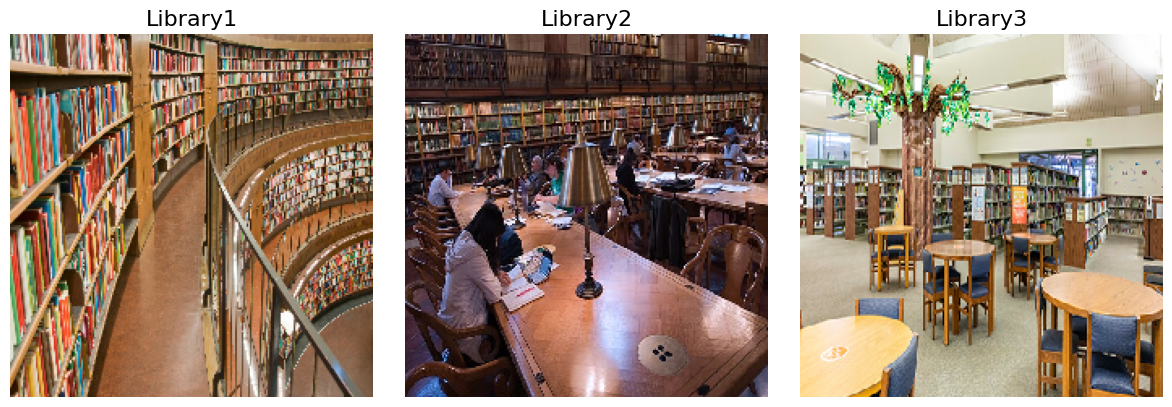

In [3]:
# Image titles
image_titles = ['Library1', 'Library2', 'Library3']

# Load images and Convert them to a Numpy array
img1 = load_img('images/library1.jpeg', target_size=(224, 224))
img2 = load_img('images/library3.jpg', target_size=(224, 224))
img3 = load_img('images/library4.png', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
indices = []
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')

    image = img_to_array(images[0])
    image = images[i].reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    pred = model.predict(image)
    # convert the probabilities to class labels
    labeltopk = decode_predictions(pred)
    # retrieve the most likely result, e.g. highest probability
    label = labeltopk[0][0]
    # print the classification
    print('Predicted label: %s (%.2f%%)' % (label[1], label[2]*100))
    print("top 5:")
    print(labeltopk)
    indices.append (np.argmax(pred))
    
plt.tight_layout()
plt.show()

## SmoothGrad

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency

#Categorical score object
score = CategoricalScore(indices)
#Score function
def score_function(output):
    return (output[0][1], output[1][294], output[2][413])

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)


C:\Users\Kvrgic\anaconda3\envs\XAI\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3, 224, 224, 3))']
  warnings.warn(msg)


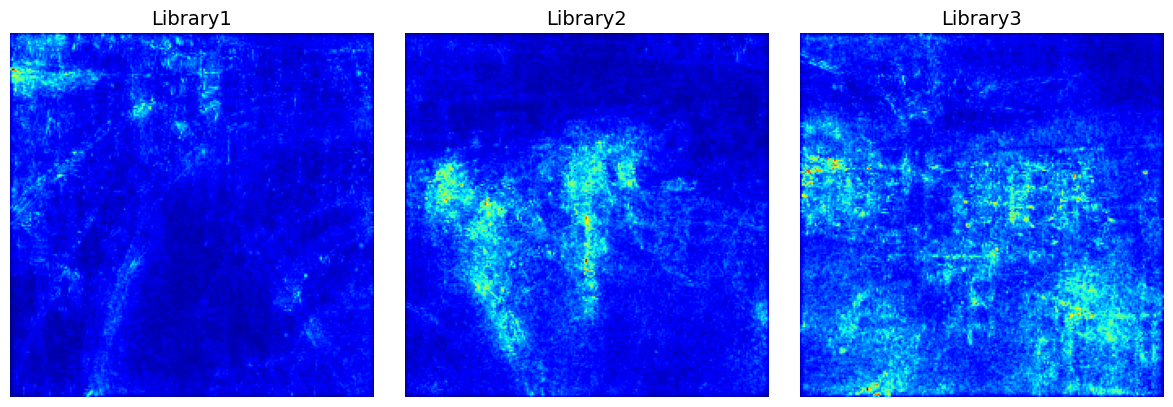

CPU times: total: 5min 18s
Wall time: 30.2 s


In [6]:
%%time
from matplotlib import cm

#Generating saliency map
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, #Number of calculating gradients iterations.
                        smooth_noise=0.20) #Noise spread level.
#Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

## RISE

In [7]:
# RISE implementation based on:
# Petsiuk, V., Das, A., & Saenko, K. (2018). RISE: Randomized Input Sampling for Explanation of Black-box Models.
# BMVC. https://github.com/eclique/RISE

In [8]:
import numpy as np
from tqdm import tqdm
from skimage.transform import resize

#GenerateS random binary masks for RISE
def generate_masks(n_masks=8000, input_size=(224, 224), mask_size=(7, 7), p=0.5):
    cell_size = (
        int(np.ceil(input_size[0] / mask_size[0])),
        int(np.ceil(input_size[1] / mask_size[1]))
    )
    up_size = (mask_size[0] * cell_size[0], mask_size[1] * cell_size[1])
    
    masks = []
    for _ in range(n_masks):
        mask = np.random.rand(*mask_size) < p
        mask = resize(mask.astype(float), up_size, order=1, mode='reflect', anti_aliasing=True)
        mask = mask[:input_size[0], :input_size[1]]
        masks.append(mask)
    masks = np.array(masks)
    return masks[..., np.newaxis]  
    
#Applies RISE to a batch of images
def apply_rise(model, images, masks, class_indices):
    n_images = images.shape[0]
    n_masks = masks.shape[0]
    heatmaps = []

    for i in tqdm(range(n_images), desc="RISE"):
        img = images[i]
        expanded_imgs = img * masks  # shape (N, H, W, 3)
        preds = model.predict(expanded_imgs, batch_size=32, verbose=0)
        class_idx = class_indices[i]
        weights = preds[:, class_idx]  # (N,)
        weighted_masks = masks * weights[:, np.newaxis, np.newaxis, np.newaxis]
        saliency = weighted_masks.mean(axis=0)  # (H, W, 1)
        heatmaps.append(saliency[..., 0])
    
    return np.array(heatmaps)


In [9]:
indices = np.argmax(model.predict(X), axis=1)
print(len(indices), len(images)) #check of indeces

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
3 3


In [10]:
masks = generate_masks(n_masks=2000)

assert len(indices) == len(X), f"Mismatch: {len(indices)} indices vs {len(X)} images!"

#making maps
rise_maps_original = apply_rise(model, X, masks, indices)


RISE: 100%|██████████| 3/3 [07:20<00:00, 146.93s/it]


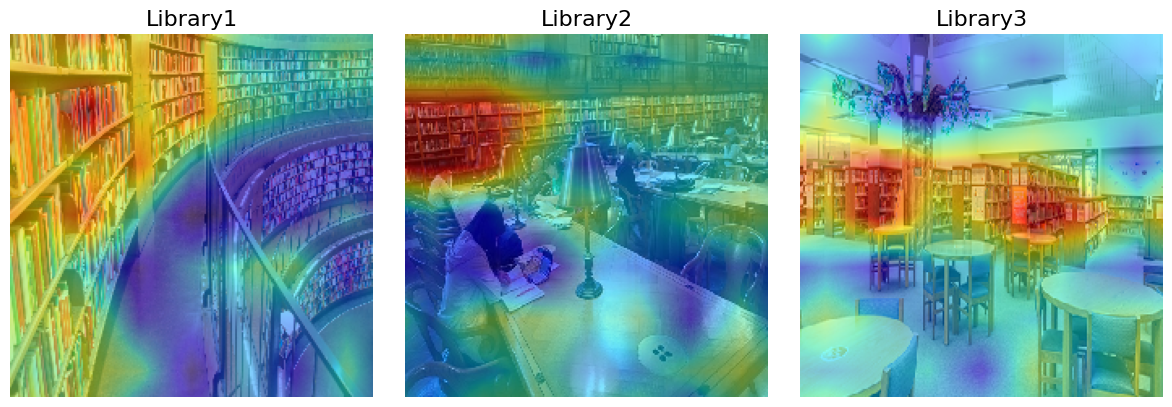

In [11]:
from matplotlib import cm

f, ax = plt.subplots(nrows=1, ncols=len(image_titles), figsize=(12, 4))

for i, title in enumerate(image_titles):
    #Normalizes and converts RISE or SmoothGrad map to a colormap
    heatmap = rise_maps_original[i]  
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  #Normalize to 0–1
    heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)  

    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])  #Original image
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)  #Overlay heatmap
    ax[i].axis('off')

plt.tight_layout()
plt.savefig('images/rise_overlay.png')
plt.show()


## Making Noisy Dataset

### Original Dataset

In [12]:
from PIL import Image
import os


#List of image filenames 
image_filenames = [
    "library1.jpeg", "library2.jpg", "library3.jpg", "library4.png",
    "mushr1.jpeg", "mushr2.jpg", "para1.jpg",
    "ship1.jpg", "ship2.jpg", "ship3.jpeg",
    "kite0.jpg", "kite3.jpg", "kite5.jpg",
    "soldiers.jpg", "source-cabernet-sauvignon.webp"
]

#LoadING unprocessed RGB images resized to 224x224
images = []
for fname in image_filenames:
    path = os.path.join("images", fname)
    img = Image.open(path).resize((224, 224)).convert("RGB")
    images.append(np.array(img))

#ConvertING to NumPy array
images = np.array(images)  

#Titles for plotting
image_titles = [os.path.splitext(name)[0].capitalize() for name in image_filenames]


### Gaussian noise

In [13]:
#Function for adding gausian noise to an image
def add_gaussian_noise(images, mean=0.0, std=25.0):
    noisy = images.copy().astype(np.float32)
    noise = np.random.normal(loc=mean, scale=std, size=images.shape)
    noisy += noise
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

images_gaussian = add_gaussian_noise(images)
X_gaussian = preprocess_input(images_gaussian)

### Gaussian bluring

In [14]:
import cv2
#Function for adding blur to an image
def apply_blur(images, ksize=5):
    return np.array([cv2.GaussianBlur(img, (ksize, ksize), 0) for img in images])

images_blurred = apply_blur(images)
X_blurred = preprocess_input(images_blurred)

### Horizontal flip

In [15]:
#Function for applying horizontal flip to an image
def horizontal_flip(images):
    return np.array([np.fliplr(img) for img in images])

images_flipped = horizontal_flip(images)
X_flipped = preprocess_input(images_flipped)


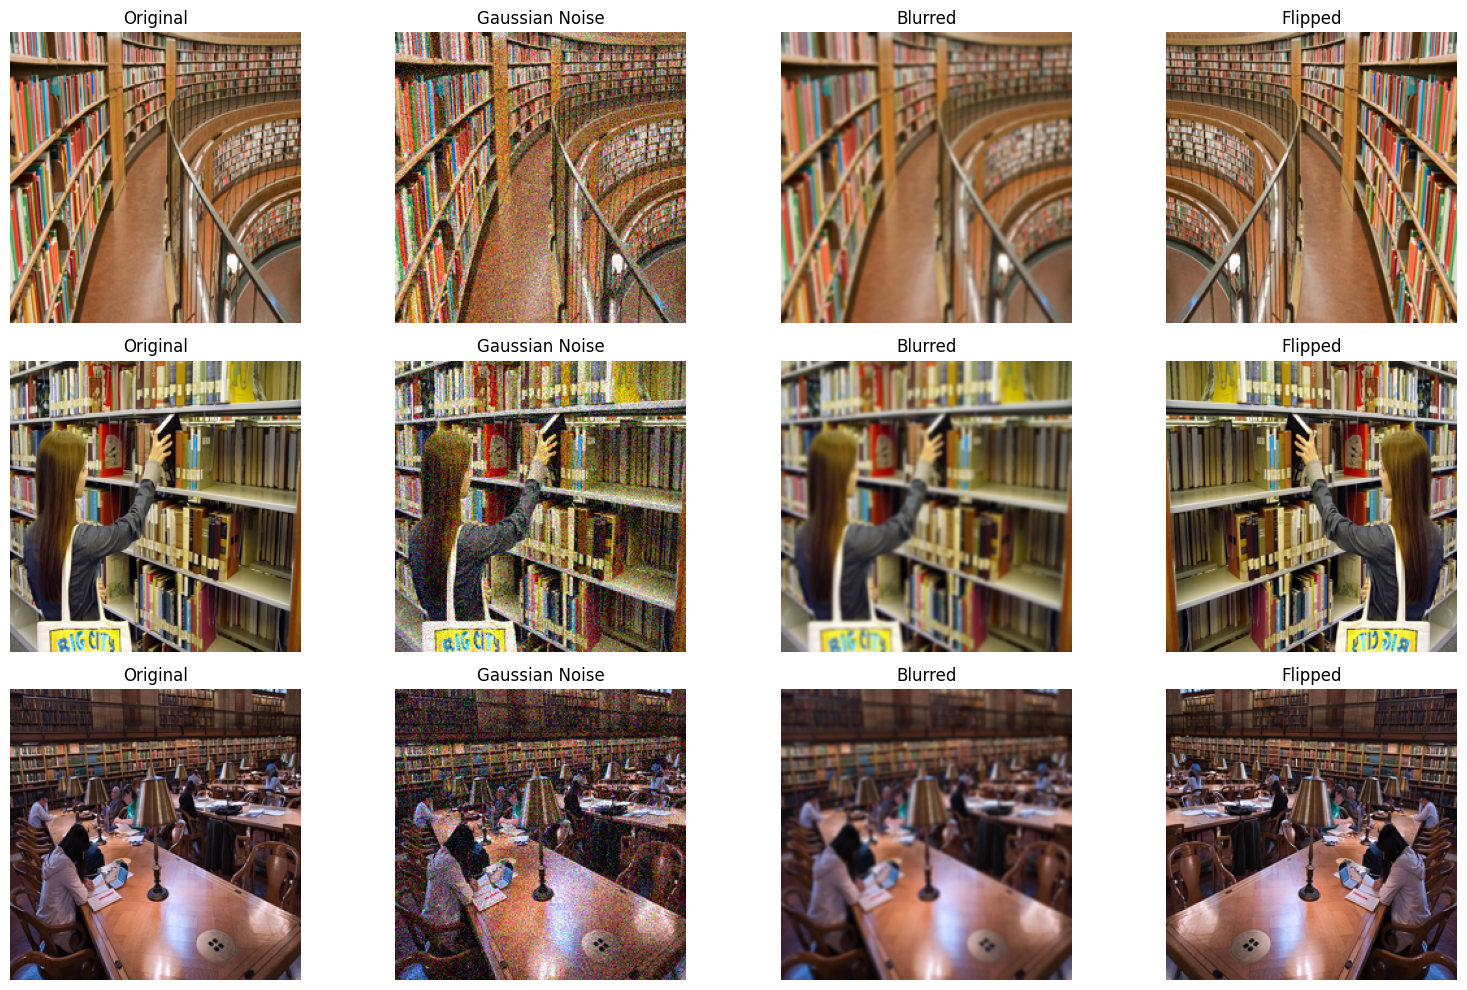

In [16]:
import matplotlib.pyplot as plt

sample_indices = [0, 1, 2]

#Titles
titles = ["Original", "Gaussian Noise", "Blurred", "Flipped"]

#Ploting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for row, idx in enumerate(sample_indices):
    axs[row, 0].imshow(images[idx].astype(np.uint8))
    axs[row, 0].set_title(titles[0])
    
    axs[row, 1].imshow(images_gaussian[idx].astype(np.uint8))
    axs[row, 1].set_title(titles[1])

    axs[row, 2].imshow(images_blurred[idx].astype(np.uint8))
    axs[row, 2].set_title(titles[2])

    axs[row, 3].imshow(images_flipped[idx].astype(np.uint8))
    axs[row, 3].set_title(titles[3])
    
    for col in range(4):
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [17]:
from tf_keras_vis.utils.scores import CategoricalScore

#Predicting the top class for each image in every set
indices_gaussian = np.argmax(model.predict(X_gaussian), axis=1)
indices_blurred = np.argmax(model.predict(X_blurred), axis=1)
indices_flipped = np.argmax(model.predict(X_flipped), axis=1)

score_gaussian = CategoricalScore(indices_gaussian.tolist())
score_blurred = CategoricalScore(indices_blurred.tolist())
score_flipped = CategoricalScore(indices_flipped.tolist())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


### Smoothgrad on Noisy Data

In [18]:
#SmoothGrad maps for each type
saliency_map_gaussian = saliency(score_gaussian, X_gaussian, smooth_samples=20, smooth_noise=0.20)
saliency_map_blurred = saliency(score_blurred, X_blurred, smooth_samples=20, smooth_noise=0.20)
saliency_map_flipped = saliency(score_flipped, X_flipped, smooth_samples=20, smooth_noise=0.20)


C:\Users\Kvrgic\anaconda3\envs\XAI\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(15, 224, 224, 3))']
  warnings.warn(msg)


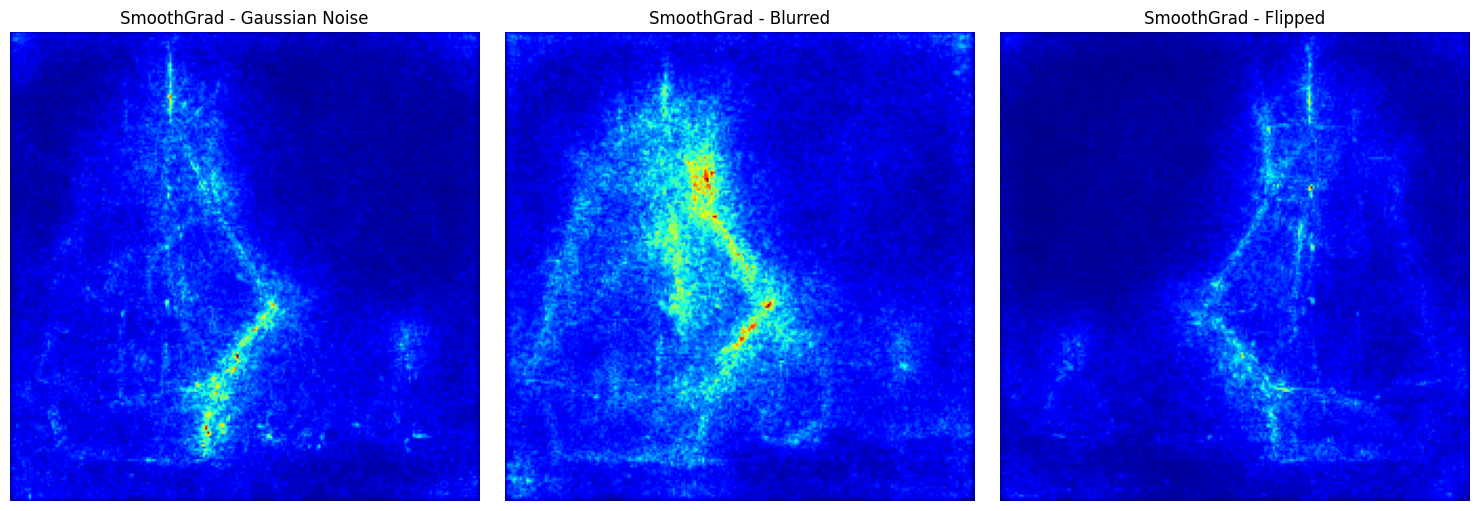

In [19]:
import matplotlib.pyplot as plt

i = 8  #Index of the image you want to visualize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(images[i])
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[0].imshow(saliency_map_gaussian[i], cmap='jet')
axs[0].set_title("SmoothGrad - Gaussian Noise")
axs[0].axis('off')

axs[1].imshow(saliency_map_blurred[i], cmap='jet')
axs[1].set_title("SmoothGrad - Blurred")
axs[1].axis('off')

axs[2].imshow(saliency_map_flipped[i], cmap='jet')
axs[2].set_title("SmoothGrad - Flipped")
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [20]:
print("Min/max values of saliency maps:")
print("Gaussian:", np.min(saliency_map_gaussian[3]), np.max(saliency_map_gaussian[3]))
print("Blurred:", np.min(saliency_map_blurred[3]), np.max(saliency_map_blurred[3]))
print("Flipped:", np.min(saliency_map_flipped[3]), np.max(saliency_map_flipped[3]))


Min/max values of saliency maps:
Gaussian: 0.0 0.99966604
Blurred: 0.0 0.99971575
Flipped: 0.0 0.99968374


### RISE on Noisy Data

In [21]:
#Getting maps for RISE
rise_maps_gaussian = apply_rise(model, X_gaussian, masks, indices_gaussian)
rise_maps_blurred = apply_rise(model, X_blurred, masks, indices_blurred)
rise_maps_flipped = apply_rise(model, X_flipped, masks, indices_flipped)



RISE: 100%|██████████| 15/15 [37:30<00:00, 150.02s/it]


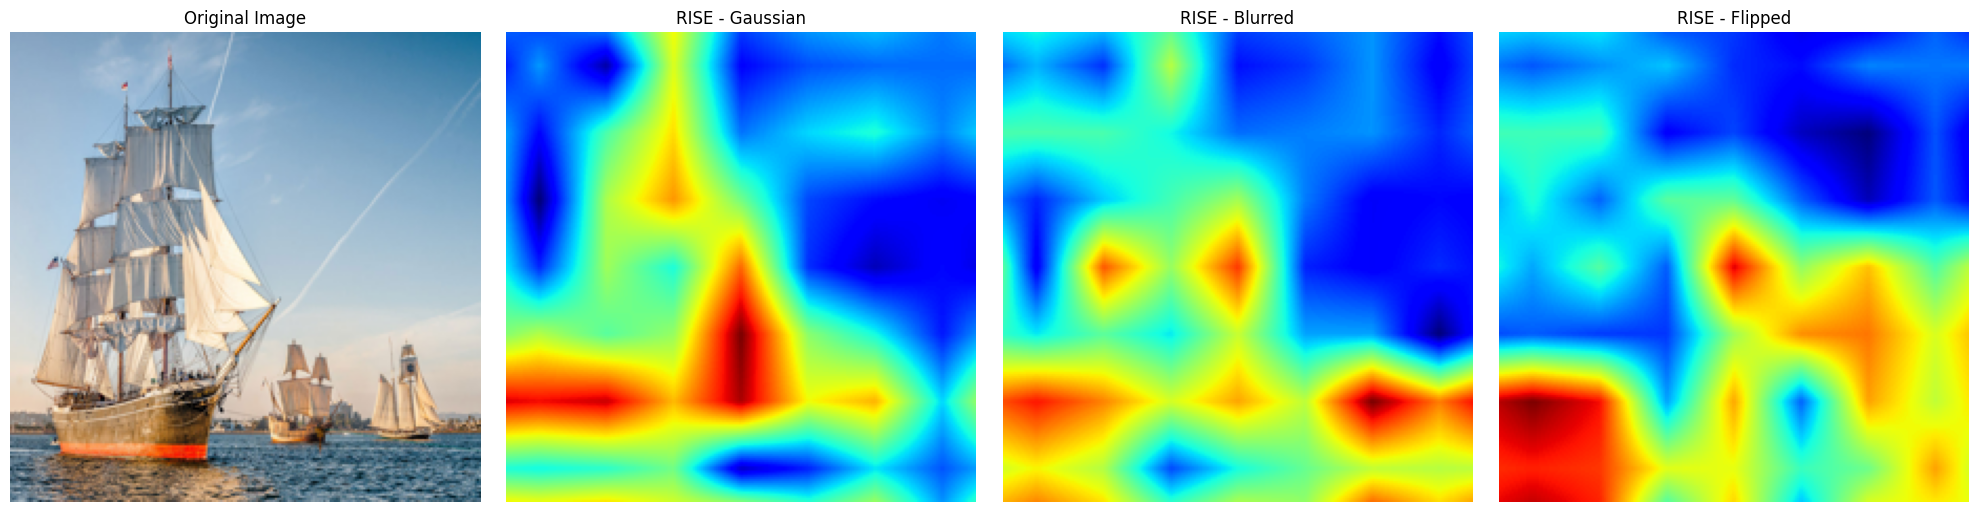

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

i = 8

axs[0].imshow(images[i])
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(rise_maps_gaussian[i], cmap='jet')
axs[1].set_title("RISE - Gaussian")

axs[2].imshow(rise_maps_blurred[i], cmap='jet')
axs[2].set_title("RISE - Blurred")

axs[3].imshow(rise_maps_flipped[i], cmap='jet')
axs[3].set_title("RISE - Flipped")

for ax in axs[1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Evaluation

In [25]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
#SSIM evaluation metric
def compute_ssim_mapwise(maps1, maps2):
    return [ssim(m1, m2, data_range=1.0) for m1, m2 in zip(maps1, maps2)]

#Cosine simmilarity evaluation metric
def compute_cosine_similarity_mapwise(maps1, maps2):
    return [cosine_similarity(m1.flatten().reshape(1, -1), m2.flatten().reshape(1, -1))[0][0]
            for m1, m2 in zip(maps1, maps2)]
#MSE evaluation metric
def compute_mse_mapwise(maps1, maps2):
    return [mean_squared_error(m1.flatten(), m2.flatten()) for m1, m2 in zip(maps1, maps2)]

#Comparission set for evaluatiom
comparison_sets = {
    'Gaussian': (saliency_map, saliency_map_gaussian, rise_maps_original, rise_maps_gaussian),
    'Blurred': (saliency_map, saliency_map_blurred, rise_maps_original, rise_maps_blurred),
    'Flipped': (saliency_map, saliency_map_flipped, rise_maps_original, rise_maps_flipped)
}

#Evaluating and storing the results
results = {}
for name, (sg_orig, sg_pert, rise_orig, rise_pert) in comparison_sets.items():
    results[name] = {
        'SmoothGrad': {
            'SSIM': np.mean(compute_ssim_mapwise(sg_orig, sg_pert)),
            'Cosine': np.mean(compute_cosine_similarity_mapwise(sg_orig, sg_pert)),
            'MSE': np.mean(compute_mse_mapwise(sg_orig, sg_pert))
        },
        'RISE': {
            'SSIM': np.mean(compute_ssim_mapwise(rise_orig, rise_pert)),
            'Cosine': np.mean(compute_cosine_similarity_mapwise(rise_orig, rise_pert)),
            'MSE': np.mean(compute_mse_mapwise(rise_orig, rise_pert))
        }
    }

#Converting to data frame
df_results = pd.DataFrame.from_dict({(i, j): results[i][j] 
                                     for i in results.keys() 
                                     for j in results[i].keys()},
                                    orient='index')
print(df_results.round(4))


                       SSIM  Cosine     MSE
Gaussian SmoothGrad  0.3537  0.8744  0.0080
         RISE        0.3762  0.9963  0.1023
Blurred  SmoothGrad  0.3264  0.8493  0.0104
         RISE        0.2951  0.9961  0.1238
Flipped  SmoothGrad  0.2584  0.8353  0.0134
         RISE        0.4827  0.9964  0.1047
